# **<a id="Content">HnM RecSys Notebook 9417</a>**

## **<a id="Content">Table of Contents</a>**
* [**<span>1. Imports</span>**](#Imports)  
* [**<span>2. Pre-Processing</span>**](#Pre-Processing)
* [**<span>3. Exploratory Data Analysis</span>**](#EDA)  
    * [**<span>3.1 Articles</span>**](#EDA::Articles)  
    * [**<span>3.2 Customers</span>**](#EDA::Customers)
    * [**<span>3.3 Transactions</span>**](#EDA::Transactions)
* [**<span>4. Models</span>**](#Models)  
    * [**<span>4.1 ALS</span>**](#ALS)  
    * [**<span>4.2 GBDT</span>**](#GBDT)  



## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import re
import warnings
# import cudf # switch on P100 GPU for this to work

# Importing data
articles = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv')
print(articles.head())
print("--")
customers = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv')
print(customers.head())
print("--")
transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
print(transactions.head())
print("--")

   article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid               

## Pre-Processing

In [24]:
# ----- empty value stats -------------
print("Missing values: ")
print(customers.isnull().sum())
print("--\n")

print("FN Newsletter vals: ", customers['FN'].unique())
print("Active communication vals: ",customers['Active'].unique())
print("Club member status vals: ", customers['club_member_status'].unique())
print("Fashion News frequency vals: ", customers['fashion_news_frequency'].unique())
print("--\n")

# ---- data cleaning -------------
customers['FN'] = customers['FN'].fillna(0)
customers['Active'] = customers['Active'].fillna(0)

# replace club_member_status missing values with 'LEFT CLUB' --> no members with LEFT CLUB status in data
customers['club_member_status'] = customers['club_member_status'].fillna('LEFT CLUB')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('None')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('NONE', 'None')
customers['age'] = customers['age'].fillna(customers['age'].mean())
customers['age'] = customers['age'].astype(int)
articles['detail_desc'] = articles['detail_desc'].fillna('None')

print("Missing values: ")
print(customers.isnull().sum())
print("--\n")

Missing values: 
customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
postal_code               0
dtype: int64
--

FN Newsletter vals:  [0. 1.]
Active communication vals:  [0. 1.]
Club member status vals:  ['ACTIVE' 'LEFT CLUB' 'PRE-CREATE']
Fashion News frequency vals:  ['None' 'Regularly' 'Monthly']
--

Missing values: 
customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
postal_code               0
dtype: int64
--



## EDA

### EDA::Articles

<b>Article data:</b>

`article_id` : Unique id for every article of clothing<br>

Observing the structure of the column info, this indentation structure of features satisfied article identification: <br>

- `<index_group_no>` and `<index_group_name>` :: <b>(clothing categories)</b>
	- `<index_name>` and `<index_group_no>` :: <b>(clothing categories' sub-groups) -- same as index group if no subgroups for a category</b>
		- `<section_name>` and `<section_no>` :: <b>(clothing collections)</b>
			- `<garment_group_name>` and `<garment_group_no>` :: <b>(garment groups)</b>
				- `<product_group_name>` and `<product_group_no>` :: <b>(product groups)</b>
					- `<product_type_name>` and `<prod_type_no>` :: <b>(product types)</b>
						- `<product_code>` and `<prod_name>` :: <b>(product names)</b>

Other data: <br>
`colour_*`: colour info of each article                    
`perceived_colour_*`: colour info of each article<br>
`department_*`: department info<br>
`detail_desc`: article description<br>
(we're ignoring `graphical_*` features since we are not going to use the image data)


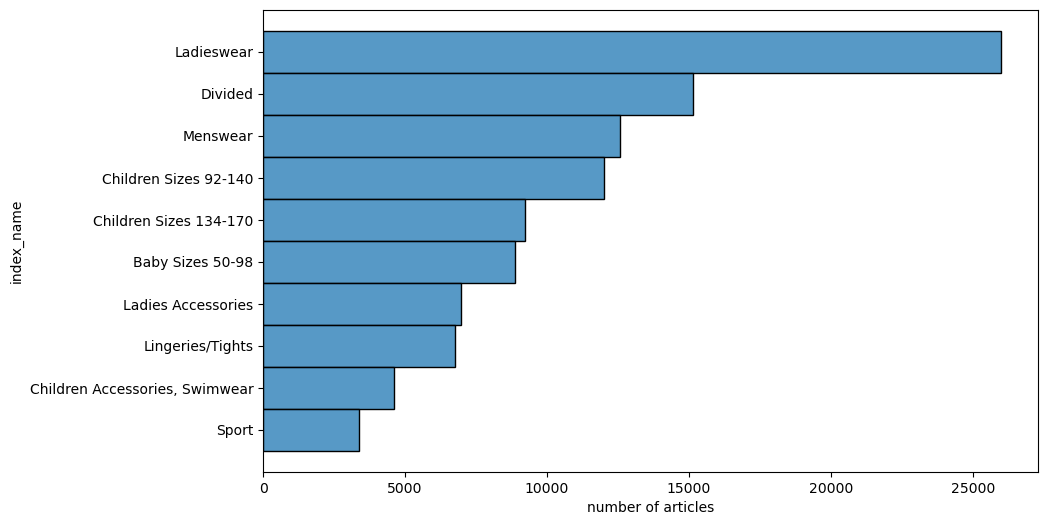

In [4]:
# Observing the most popular clothing categories (indices)

# Convert index_name to ordered categorical for ordered histplot
ordered_index_names = articles['index_name'].value_counts().index
articles['index_name'] = pd.Categorical(articles['index_name'], categories=ordered_index_names, ordered=True)

# Plot histogram
f, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=articles, y='index_name')
ax.set_xlabel('count of articles')
ax.set_ylabel('index_name')
plt.show()

The Ladieswear category and Children (aggregated) category have the most articles. The Sport category has the least articles.

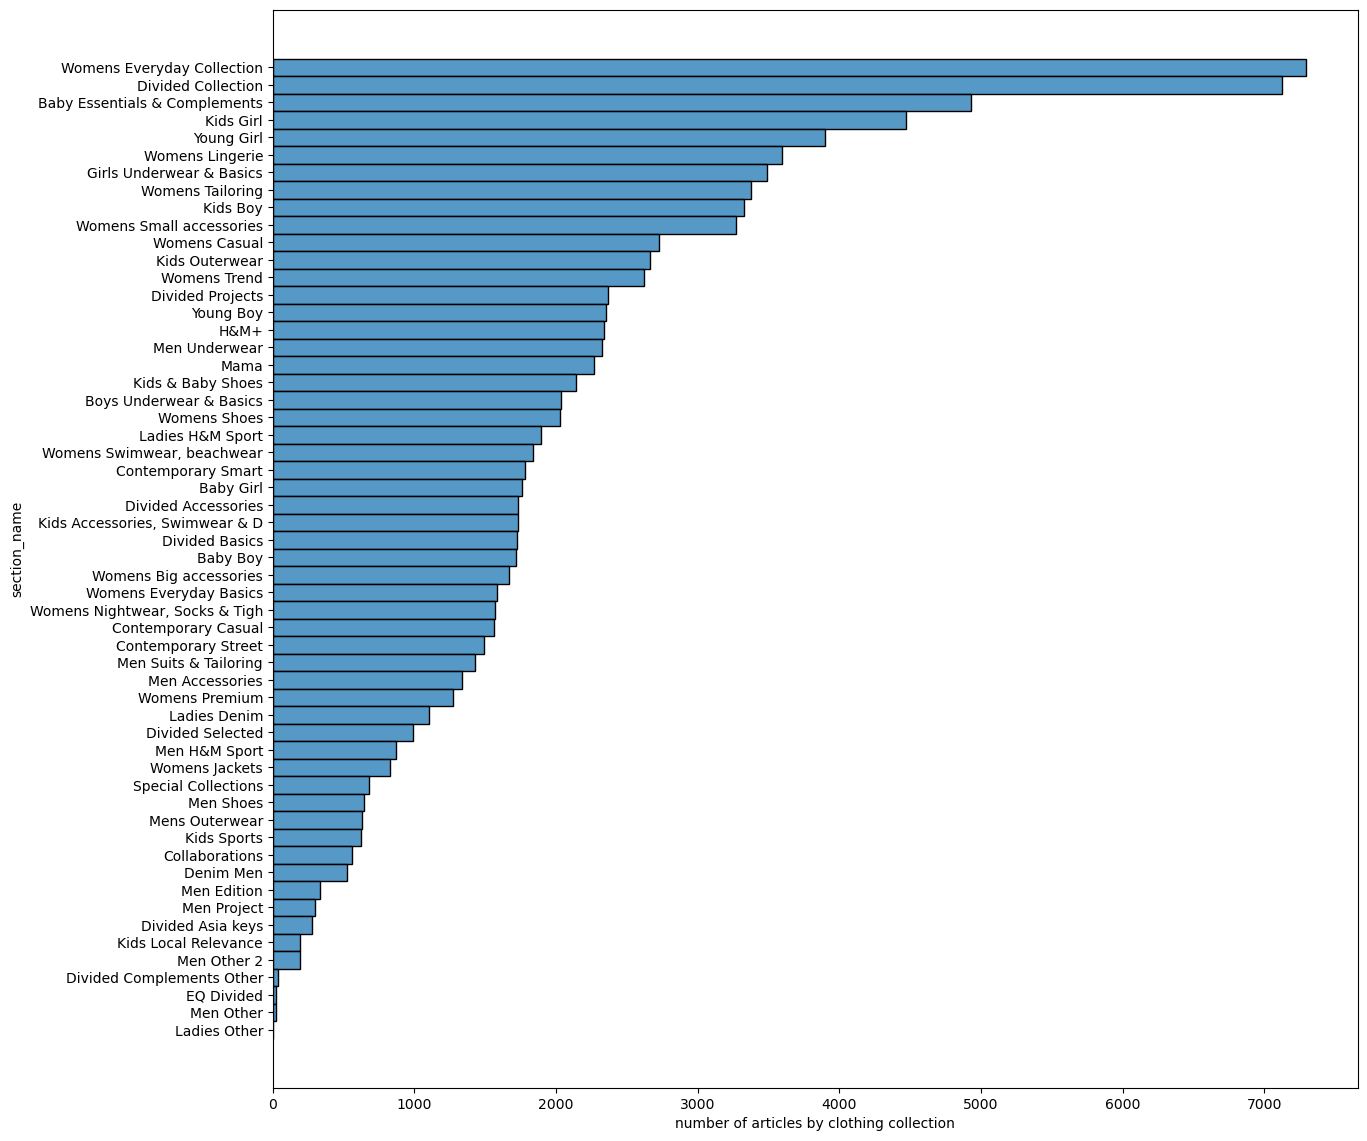

In [5]:
# Observing the most popular clothing collections (sections)

ordered_section_names = articles['section_name'].value_counts().index
articles['section_name'] = pd.Categorical(articles['section_name'], categories=ordered_section_names, ordered=True)

f, ax = plt.subplots(figsize=(14, 14))
sns.histplot(data=articles, y='section_name', bins=len(ordered_section_names))
ax.set_xlabel('count of articles by clothing collection')
ax.set_ylabel('section_name')
plt.show()

Women's Everyday Collection, followed by the miscellaneous section Divided Collection, and Baby Essentials & Complements.
Ladies Other has the least number of articles.

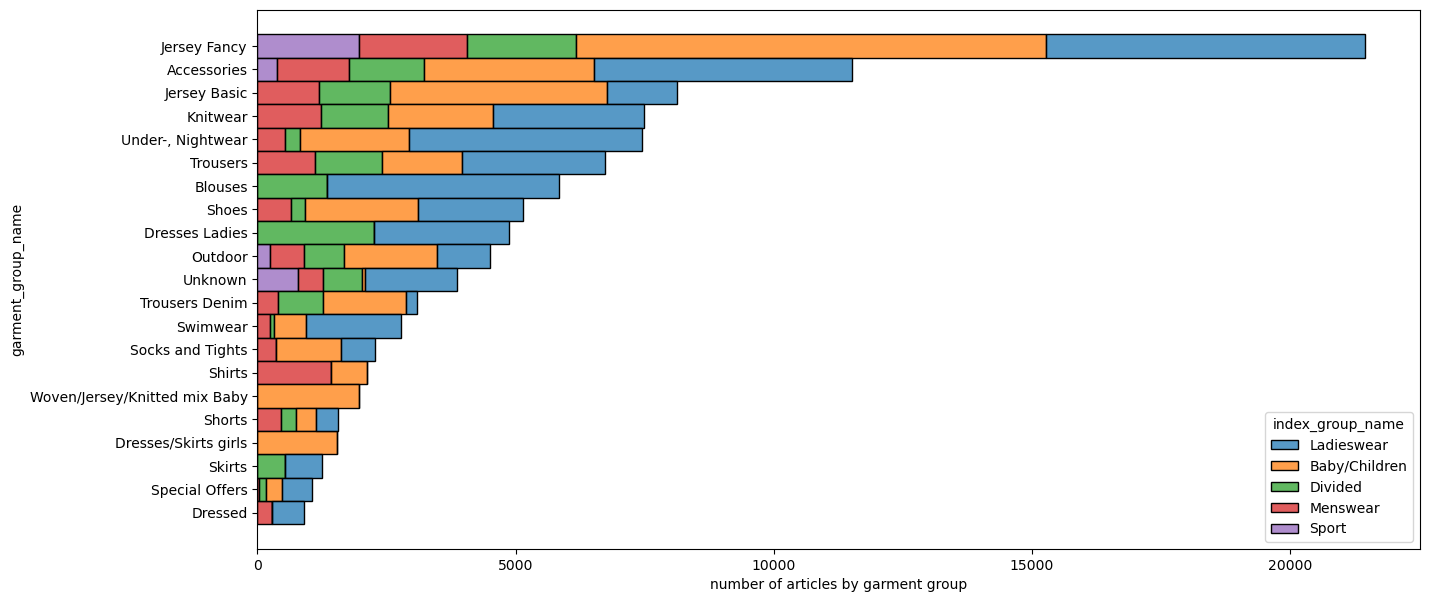

In [6]:
# Observing garments grouped by their clothing category (index_group)

ordered_garment_group_names = articles['garment_group_name'].value_counts().index
ordered_index_group_names = articles['index_group_name'].value_counts().index
articles['garment_group_name'] = pd.Categorical(articles['garment_group_name'], categories=ordered_garment_group_names, ordered=True)
articles['index_group_name'] = pd.Categorical(articles['index_group_name'], categories=ordered_index_group_names, ordered=True)

f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name', hue='index_group_name', multiple="stack")
ax.set_xlabel('count of articles by garment group')
ax.set_ylabel('garment_group_name')
plt.show()


Jersey Fancy and Accessories are the most popular garment groups; a large part of the Ladieswear and Children categories contribute to the garment group counts.

In [7]:
# Observing number of articles per clothing category

articles.groupby(['index_group_name']).count()['article_id']

index_group_name
Ladieswear       39737
Baby/Children    34711
Divided          15149
Menswear         12553
Sport             3392
Name: article_id, dtype: int64

In [8]:
# Since some clothing categories (index_group_name) have sub-categories (index_name):
# Observing number of articles per sub-category

grouped_counts = articles.groupby(['index_group_name', 'index_name']).count()['article_id']
grouped_counts = grouped_counts[grouped_counts != 0]
grouped_counts

index_group_name  index_name                    
Ladieswear        Ladieswear                        26001
                  Ladies Accessories                 6961
                  Lingeries/Tights                   6775
Baby/Children     Children Sizes 92-140             12007
                  Children Sizes 134-170             9214
                  Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
Divided           Divided                           15149
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

The clothing sub-catgeory of Ladieswear in the Ladieswear category has the most articles.<br>
The clothing sub-catgeory of Children Sizes 92-140 in the Baby/Children category has the most articles in the category.

In [9]:
# Observing number of articles by product group
grouped_counts = articles.groupby(['garment_group_name', 'product_group_name']).count()['article_id']
grouped_counts = grouped_counts[grouped_counts != 0]
grouped_counts

garment_group_name  product_group_name
Jersey Fancy        Accessories              43
                    Garment Full body      3384
                    Garment Lower body     3179
                    Garment Upper body    14356
                    Nightwear                82
                                          ...  
Special Offers      Swimwear                  8
                    Underwear                 7
Dressed             Garment Full body         2
                    Garment Upper body      905
                    Unknown                   1
Name: article_id, Length: 121, dtype: int64

In [10]:
# Observing number of articles by product groups

grouped_counts = articles.groupby(['product_group_name', 'product_type_name']).count()['article_id']
grouped_counts = grouped_counts[grouped_counts != 0]
grouped_counts

product_group_name   product_type_name
Accessories          Accessories set         7
                     Alice band              6
                     Baby Bib                3
                     Bag                  1280
                     Beanie                 56
                                          ... 
Underwear            Underwear corset        7
                     Underwear set          47
Underwear/nightwear  Sleep Bag               6
                     Sleeping sack          48
Unknown              Unknown               121
Name: article_id, Length: 132, dtype: int64

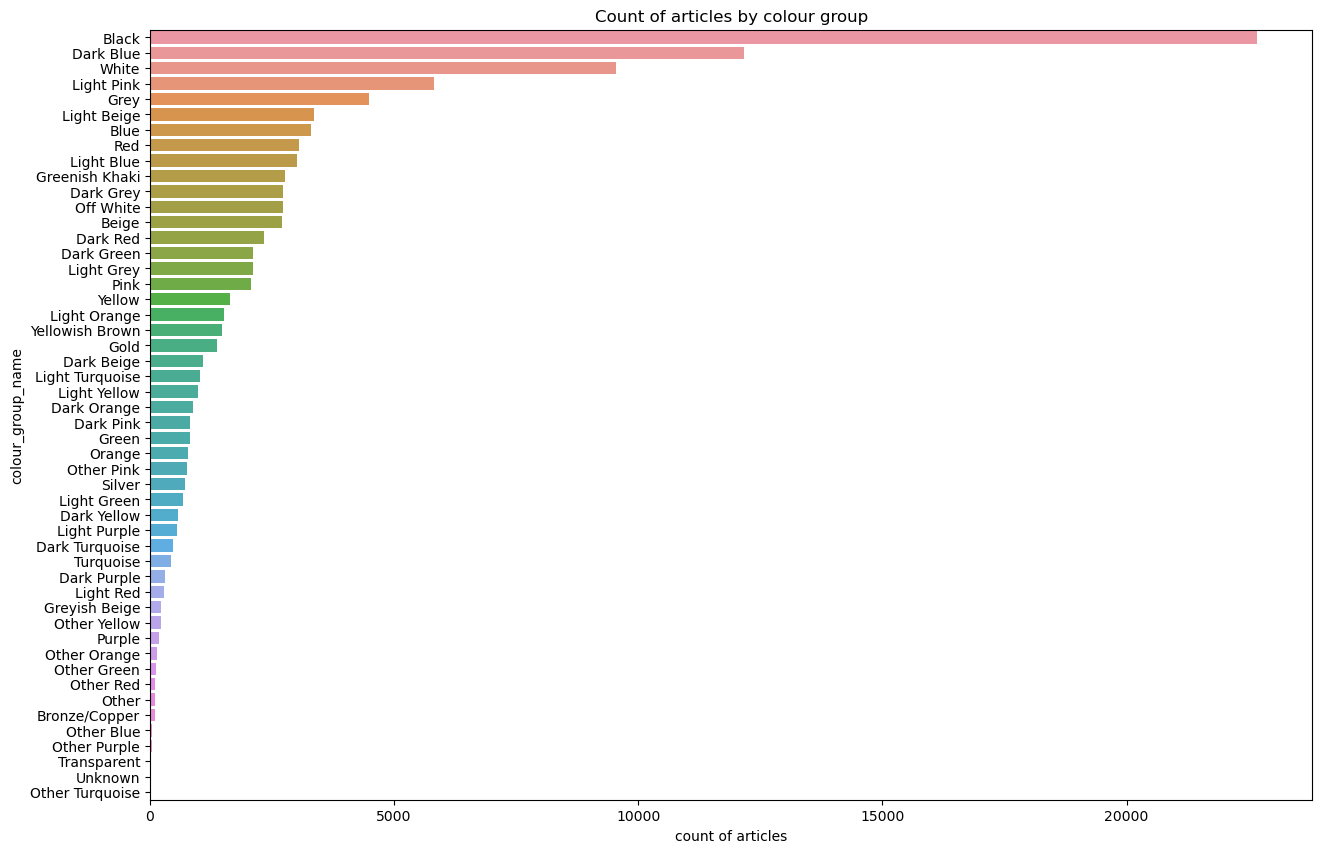

In [32]:
# Observing the most popular colours for articles

ordered_colour_names = articles['colour_group_name'].value_counts().index
articles['colour_group_name'] = pd.Categorical(articles['colour_group_name'], categories=ordered_colour_names, ordered=True)

f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='colour_group_name', data=articles, order=ordered_colour_names)
ax.set_xlabel('count of articles')
ax.set_ylabel('colour_group_name')
ax.set_title('Count of articles by Colour Group')
plt.show()

Black, dark blue and white are the most popular colours overall.

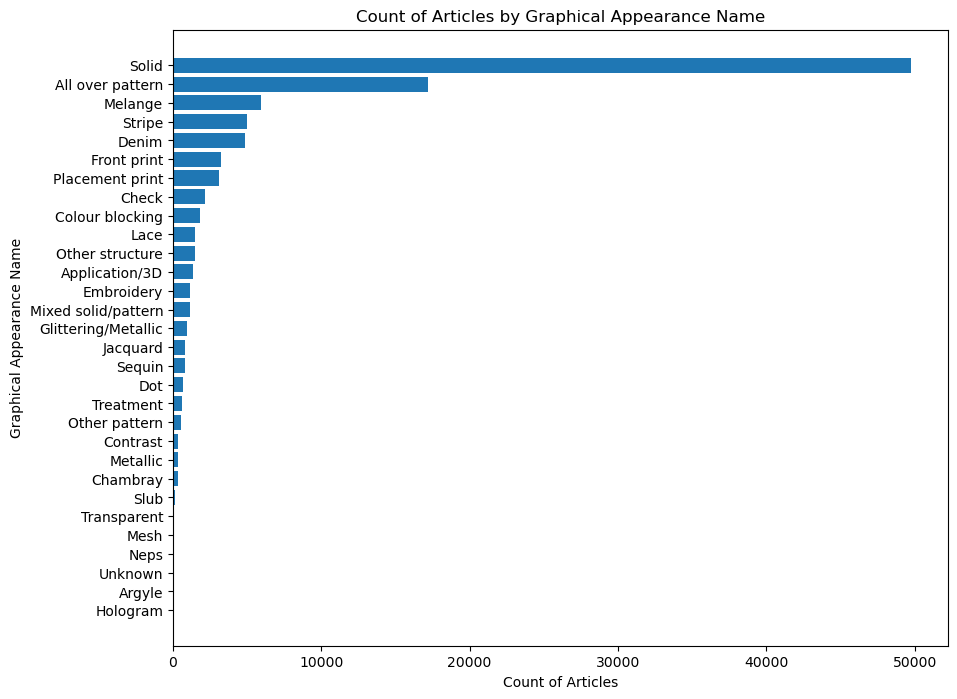

In [35]:
# Observing the most popular graphics for articles

count_by_graphical_appearance = articles['graphical_appearance_name'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(count_by_graphical_appearance.index, count_by_graphical_appearance.values)
ax.set_title('Count of Articles by Graphical Appearance')
ax.set_xlabel('count of articles')
ax.set_ylabel('graphical_appearance_name')
plt.show()

A Solid pattern on articles is most popular.

### EDA::Customers

<b>Customer data:</b>

`customer_id` : Unique id for every customer<br>
`FN` (Does the customer receive fashion news): 1 or 0 <br>
`Active` (Is the customer active for communication): 1 or 0<br>
`club_member_status` (Customer's club status): 'ACTIVE' or 'PRE-CREATE' or 'LEFT CLUB'<br>
`fashion_news_frequency` (How often H&M may send news to customer): 'Regularly' or 'Monthly' or 'None'<br>
`age` : Customer's age<br>
`postal_code` : Customer's postal code<br>

In [11]:
# Observing postal code counts

top_5_postal_codes = customers['postal_code'].value_counts().head(5)
print(top_5_postal_codes)

2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    120303
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8       261
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1       159
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7       157
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145       156
Name: postal_code, dtype: int64


Clearly, the most common postal code is either some default postal code or a centralized delivery location.

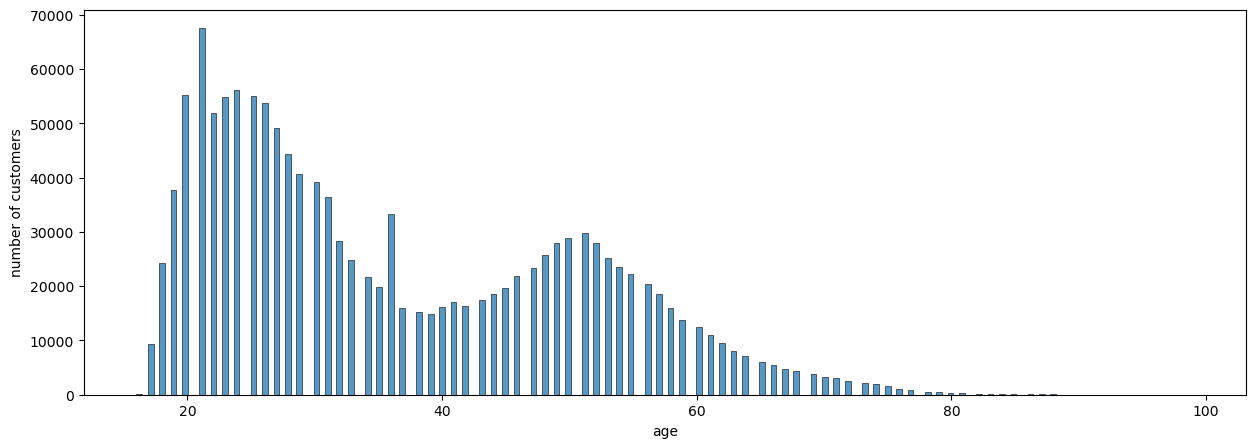

In [12]:
# Observing the customer age distribution

f, ax = plt.subplots(figsize=(15,5))
sns.histplot(data=customers, x='age')
ax.set_ylabel('number of customers')
plt.show()

In [13]:
top_5_ages = customers['age'].value_counts().head(5)
print(top_5_ages)

21    67530
24    56124
20    55196
25    54989
23    54867
Name: age, dtype: int64


Clearly, the age range of 20-25 has the most customers.

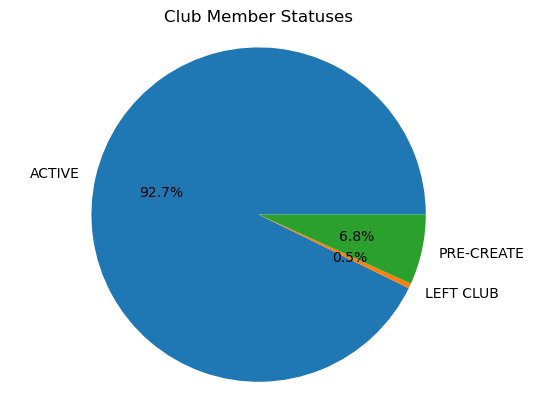

In [14]:
# Observing the club member status of customers

# Group the customers by club member status and count the number of customers in each group
club_member_counts = customers.groupby('club_member_status')['customer_id'].count()

# Pie chart
plt.pie(club_member_counts.values, labels=club_member_counts.index, autopct='%1.1f%%')
plt.title('Club Member Statuses')
plt.axis('equal')
plt.show()

An overwhelming majority of customers currently have an active club status.

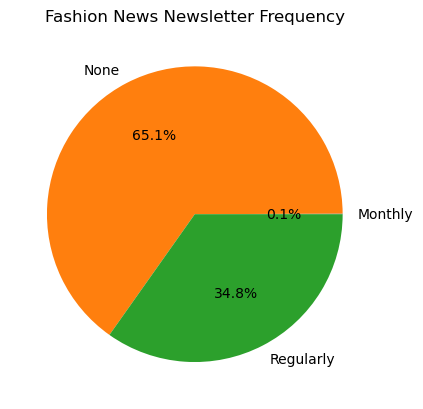

In [15]:
# Observing the FN subscription of customers

news_frequency_counts = customers.groupby('fashion_news_frequency')['customer_id'].count()

# create a pie chart
plt.pie(news_frequency_counts, labels=news_frequency_counts.index, autopct='%1.1f%%')
plt.title('Fashion News Newsletter Frequency')
plt.show()

A majority of customers don't subsribe to the fashion newsletter.

### EDA::Transactions

<b>Transaction data:</b>

`t_dat`: date the transaction occured in yyyy-mm-dd format <br>
`customer_id`: in customers df <br>
`article_id` in articles df <br>
`price`: geneneralized price (not a currency or unit) <br>
`sales_channel_id`: 1 = in-store or 2 = online <br>

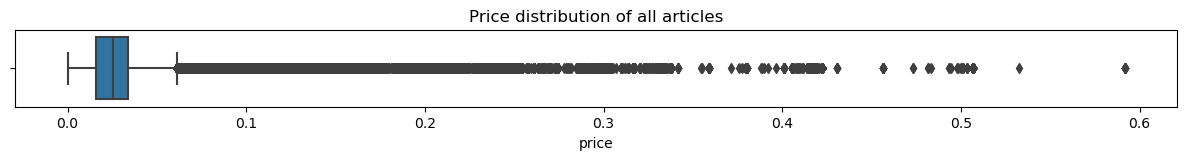

count   31788324.0000
mean           0.0278
std            0.0192
min            0.0000
25%            0.0158
50%            0.0254
75%            0.0339
max            0.5915
Name: price, dtype: float64

In [16]:
f, ax = plt.subplots(figsize=(15,1))
ax.set_title('Price distribution of all articles')
sns.boxplot(x='price', data=transactions)
plt.show()
pd.set_option('display.float_format', '{:.4f}'.format)
transactions.describe()['price']

The prices seem to vary a lot across all articles, so the above plot doesn't give us useful information. <br>
The total transaction count is ~3 million, so we'll use a 100,000 sample from the transaction data as needed.

In [17]:
# merging transactions and artciles df on aritcle_id

articles_product_columns = articles[['article_id', 'index_name', 'product_group_name', 'product_type_name', 'prod_name']]
# merged_table_ta --> merged_table_transactions_articles
merged_table_ta = transactions[['customer_id', 'article_id', 'price', 'sales_channel_id','t_dat']].merge(articles_product_columns, on='article_id', how='left')


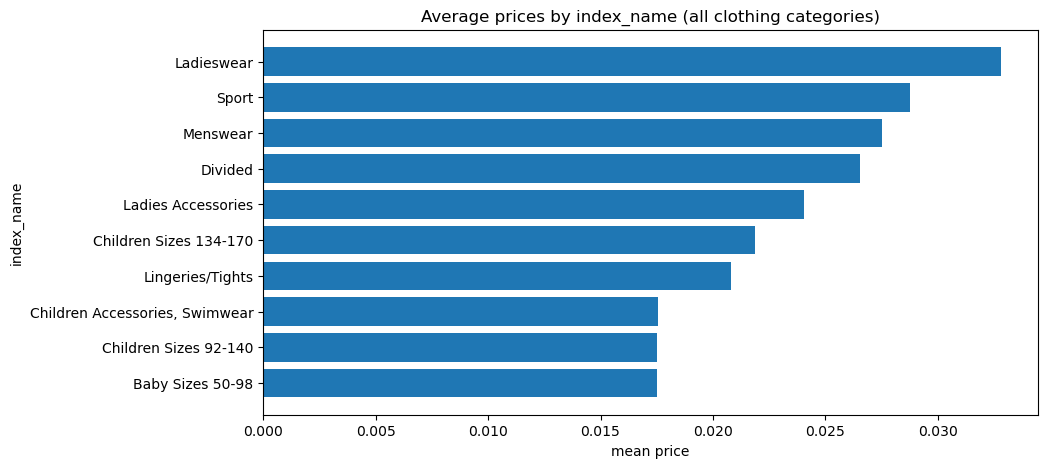

In [18]:
# Observing the mean price of each sub-clothing catgeory (index_name)

# Group the data by index_name and calculate the mean price for each group
price_by_index_name = merged_table_ta.groupby('index_name')['price'].mean()
price_by_index_name = price_by_index_name.sort_values(ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(price_by_index_name.index, price_by_index_name.values)
ax.set_title('Average prices by index_name (all clothing categories)')
ax.set_xlabel('mean price')
ax.set_ylabel('index_name')
plt.show()

The Ladieswear sub-category in the Ladieswear category has the largest mean price.

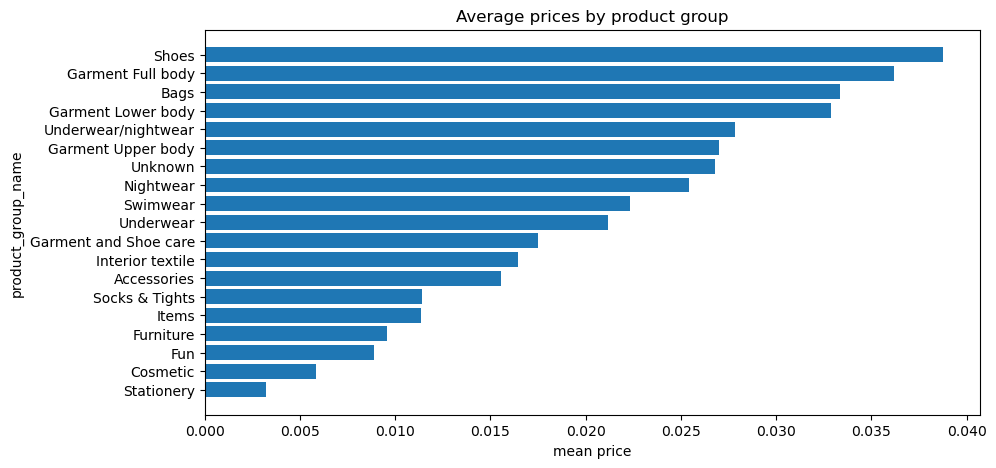

In [19]:
# Observing the mean price of each product group

# Group the data by product_group_name and calculate the mean price for each group
price_by_product_group = merged_table_ta[['product_group_name', 'price']].groupby('product_group_name').mean()
price_by_product_group = price_by_product_group.sort_values(by='price', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(price_by_product_group.index, price_by_product_group['price'])
ax.set_title('Average prices by product group')
ax.set_xlabel('mean price')
ax.set_ylabel('product_group_name')
plt.show()

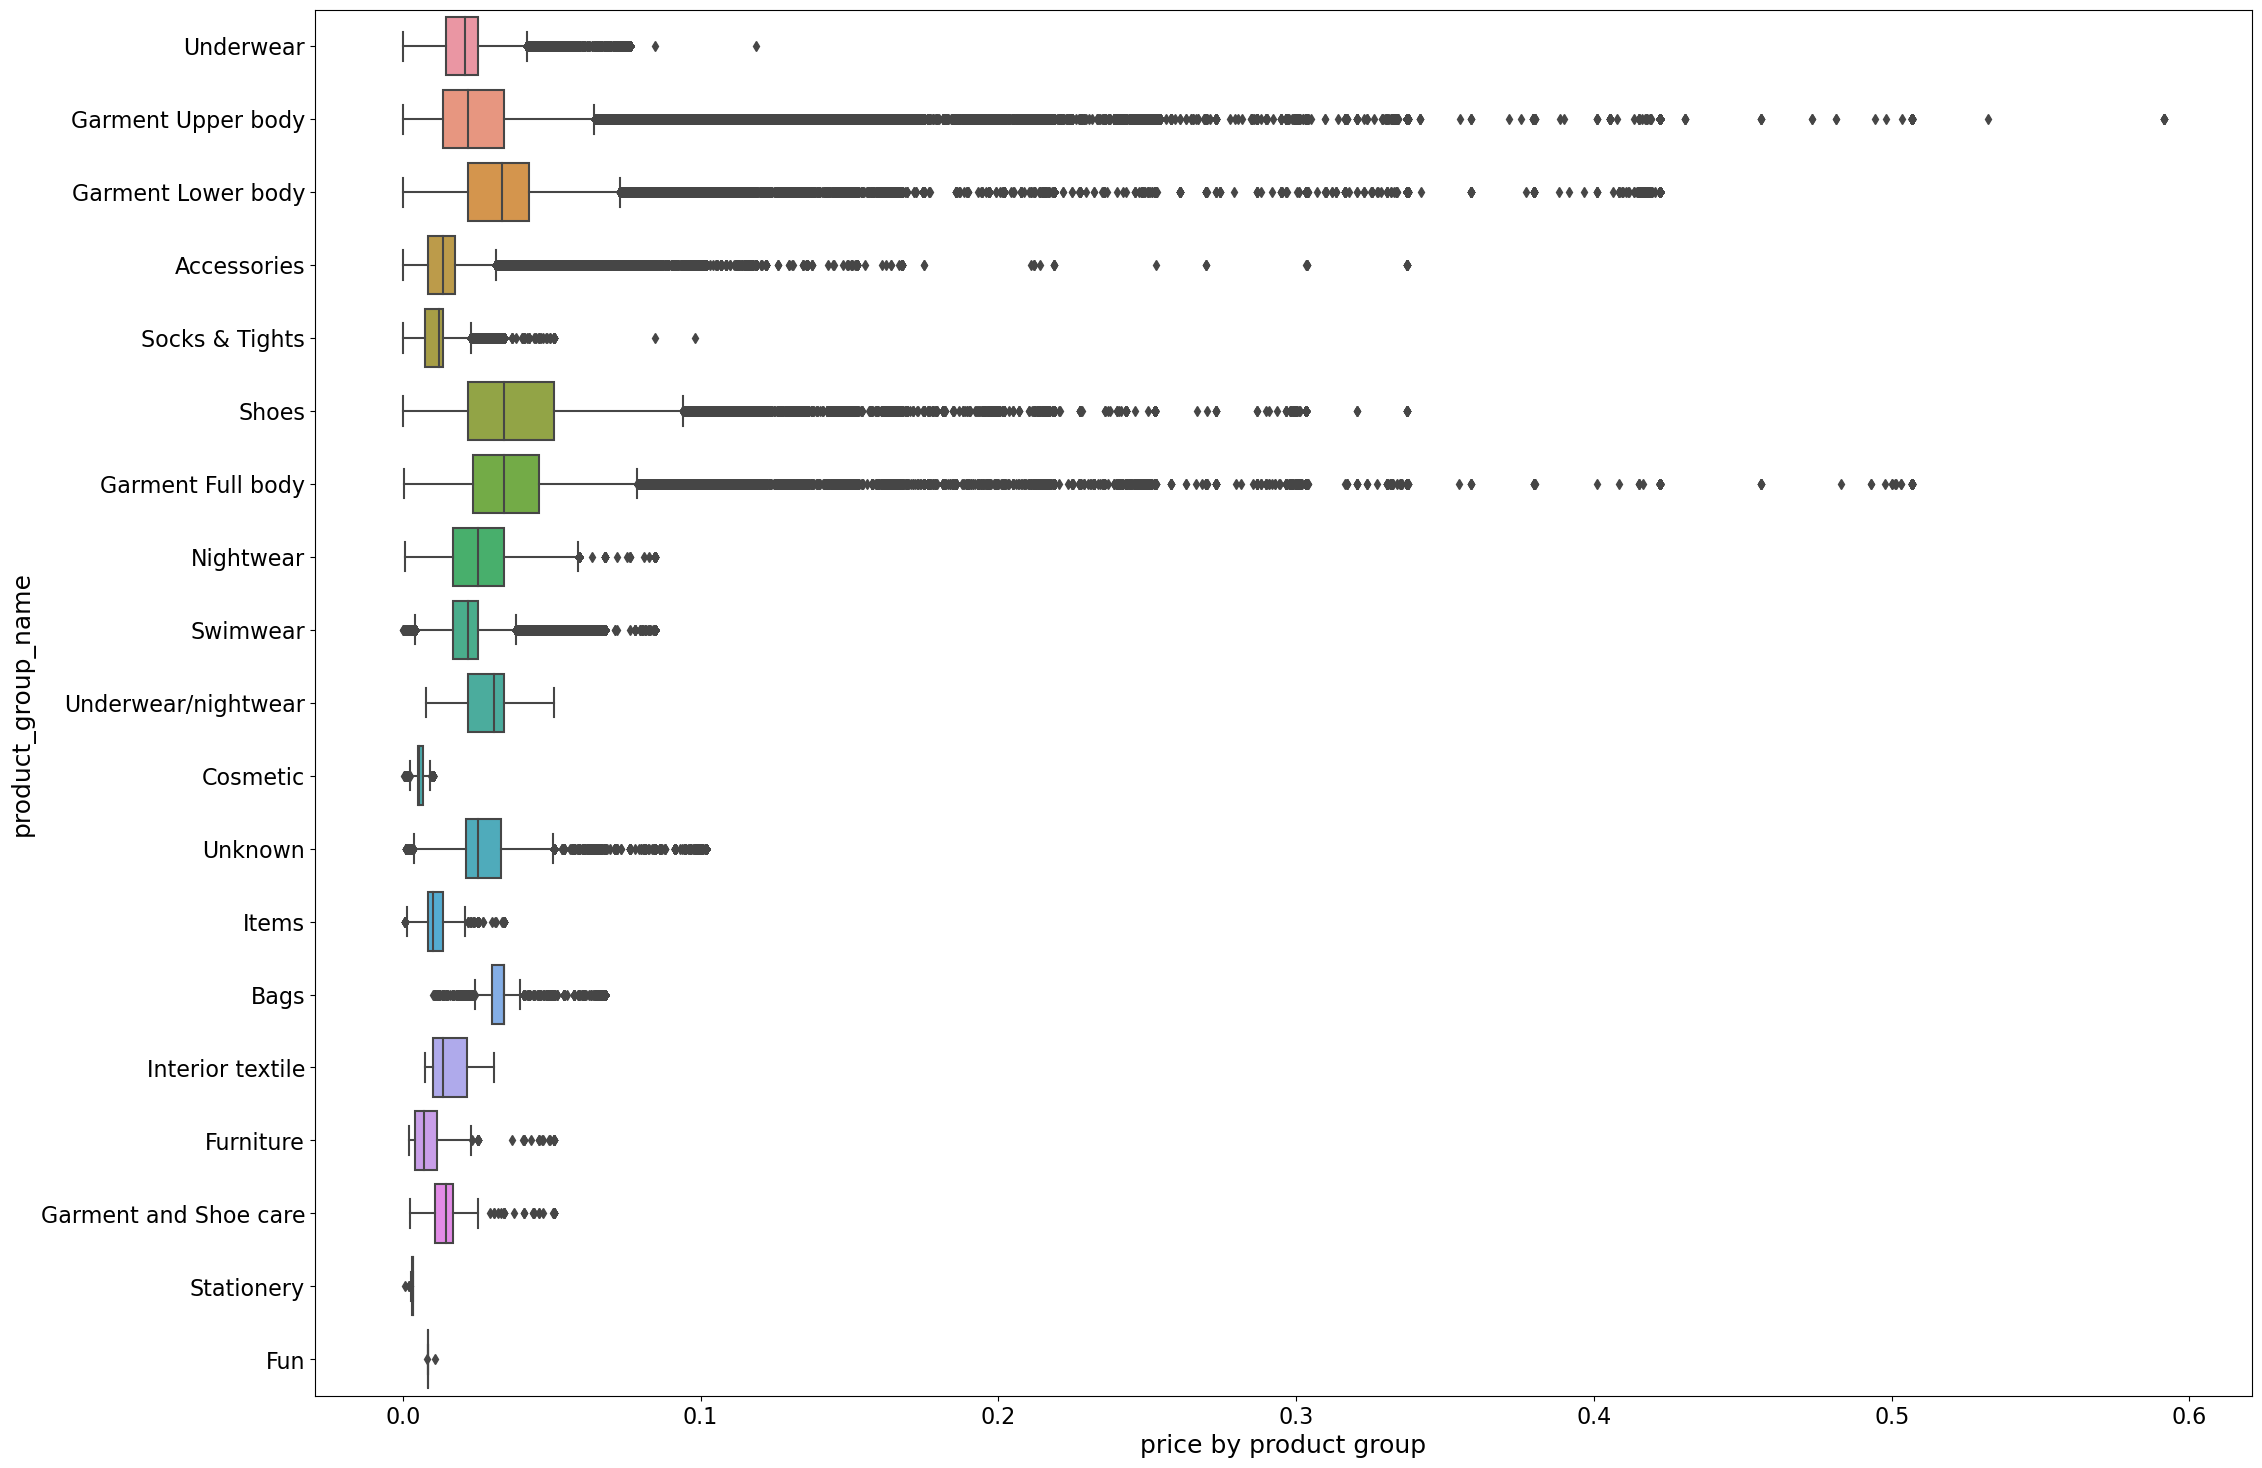

In [20]:
# Observing price distributions by product group 

# plot all boxplots
f, ax = plt.subplots(figsize=(25,18))
ax = sns.boxplot(data=merged_table_ta, x='price', y='product_group_name')
ax.set_xlabel('price by product group', fontsize=18)
ax.set_ylabel('product_group_name', fontsize=18)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.show()

The prices for product groups Garment upper/lower/full and Shoes have a large variance in prices. <br> This is reasnonable since the price can vary between different clothing collections of the same product group (Ex. premium full garmnet collection vs an on-sale garment collection).

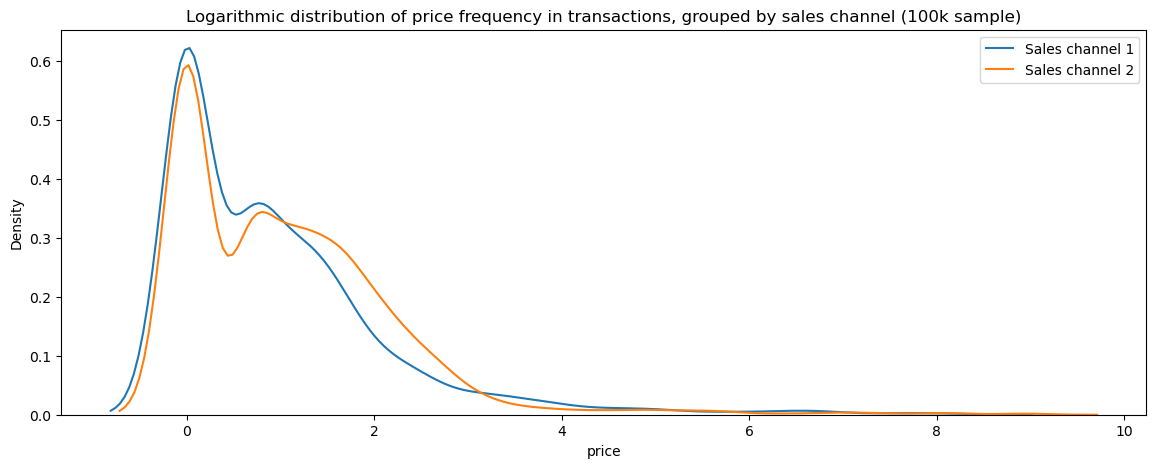

In [21]:
# Observing the distribution of price frequency in samples

# Sample 100,000 observations
merged_sample = merged_table_ta.sample(n=100000)

# using kdeplots to plot probability dist. of price values
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
sns.kdeplot(np.log(merged_sample.loc[merged_sample["sales_channel_id"]==1].price.value_counts()))
sns.kdeplot(np.log(merged_sample.loc[merged_sample["sales_channel_id"]==2].price.value_counts()))
ax.legend(labels=['Sales channel 1', 'Sales channel 2'])
plt.title("Logarithmic distribution of price frequency in transactions, grouped by sales channel (100k sample)")
plt.show()


In [22]:
# Observing the top 10 customers by number of transactions

transactions['customer_id'].value_counts().head(10)

be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
55d15396193dfd45836af3a6269a079efea339e875eff42cc0c228b002548a9d    1208
c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27cf9bda5517c8774f8fa    1170
8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d659fa4e5c3af6cc076    1169
03d0011487606c37c1b1ed147fc72f285a50c05f00b9712e0fc3da400c864296    1157
6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2e57161f0ef810a4b55    1143
Name: customer_id, dtype: int64

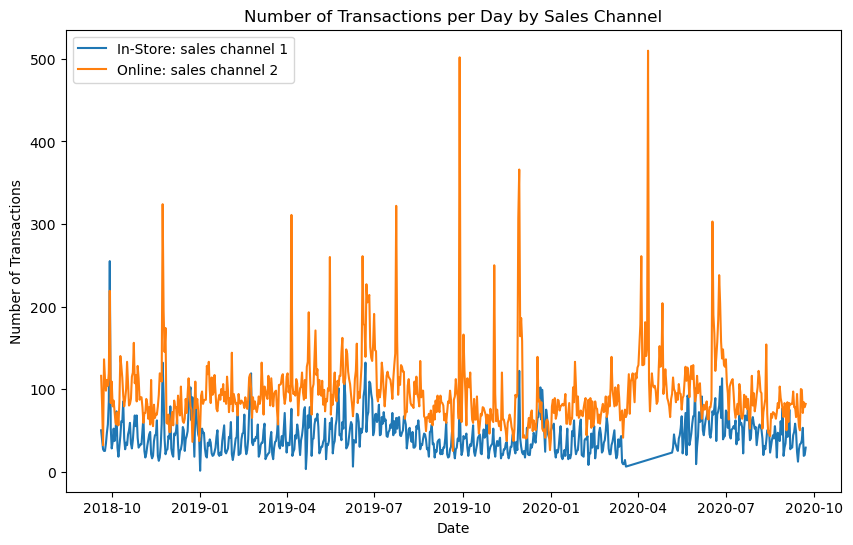

In [23]:
# Observing the number of transaction per day by sales channel

# Sample 100,000 observations
merged_table_ta_sample = merged_table_ta.sample(n=100000, random_state=69)

# Convert t_dat column to datetime format
merged_table_ta_sample['t_dat'] = pd.to_datetime(merged_table_ta_sample['t_dat'])

# Group the data by sales channel and date, and count the number of transactions for each group
transactions_by_day = merged_table_ta_sample.groupby(['sales_channel_id', pd.Grouper(key='t_dat', freq='D')])['article_id'].count()

# Create a line plot
fig, ax = plt.subplots(figsize=(10, 6))
for channel in transactions_by_day.index.levels[0]:
    if channel == 1:
        ax.plot(transactions_by_day[channel], label=f'In-Store: sales channel 1')
    else:
        ax.plot(transactions_by_day[channel], label=f'Online: sales channel 2')
ax.legend()
ax.set_title('Number of Transactions per Day by Sales Channel')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Transactions')
plt.show()


It is worth noting here that for April 2020, the number of in-store transactions is virtually nonexistent, while there is a sharp spike in online transactions for the same month; this is highly likely due to in-person stores possibly closing in April due to Covid-19.

## Models

As per `sample_submission.csv`, we have to predict the top 12 products (sorted by reccomnedation), each cutsomer would purchase.